In [2]:
import pandas as pd
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def ler_log_para_dataframe(caminho_log):
    linhas = []
    # regex ampliada para capturar também o tempo de resposta em ms
    padrao = re.compile(
        r'\[(.*?)\] IP: (.*?) \| Status: (.*?) \| Iluminação: ([\d.]+) '
        r'\| Reconhecido: (sim|não)(?: \| Usuário: (.*?)(?: \(([\d.]+)%\))?)?'
        r'(?: \| Tempo resposta: ([\d.]+(?:\.\d+)?) ms)?'
    )

    with open(caminho_log, 'r', encoding='latin1') as f:
        for linha in f:
            match = padrao.search(linha)
            if match:
                timestamp_str = match.group(1)
                timestamp = datetime.strptime(timestamp_str, '%Y-%m-%d %H:%M:%S')
                ip = match.group(2)
                status = match.group(3)
                iluminacao = float(match.group(4))
                reconhecido = match.group(5)
                usuario = match.group(6) if match.group(6) else None
                confianca = float(match.group(7)) if match.group(7) else None
                tempo_resposta = float(match.group(8)) if match.group(8) else None

                linhas.append({
                    'timestamp': timestamp,
                    'ip': ip,
                    'status': status,
                    'iluminacao': iluminacao,
                    'reconhecido': reconhecido,
                    'usuario': usuario,
                    'confianca': confianca,
                    'tempo_resposta_ms': tempo_resposta
                })

    df = pd.DataFrame(linhas)
    return df


In [4]:
def adicionar_faixas_iluminacao(df: pd.DataFrame) -> pd.DataFrame:
    # ajuste os limites conforme seu cenário/câmera
    bins = [0, 30, 60, 100, 150, 255, float("inf")]
    labels = [
        "0–30 (muito escuro)",
        "30–60 (escuro)",
        "60–100 (ok)",
        "100–150 (claro)",
        "150–255 (muito claro)",
        ">=255 (estourado)"
    ]
    df = df.copy()
    df["faixa_luz"] = pd.cut(df["iluminacao"], bins=bins, labels=labels, right=True, include_lowest=True)
    return df

In [5]:
def grafico_barras_empilhadas_por_luz(df: pd.DataFrame, titulo: str = "Tipos de detecção por faixa de luminosidade"):
    # tabela de contagem
    ct = pd.crosstab(df["faixa_luz"], df["status"]).fillna(0).astype(int)

    # garante ordem lógica dos rótulos das faixas
    categorias_ordem = [c for c in [
        "0–30 (muito escuro)", "30–60 (escuro)", "60–100 (ok)",
        "100–150 (claro)", "150–255 (muito claro)", ">=255 (estourado)"
    ] if c in ct.index]
    ct = ct.reindex(categorias_ordem)

    # plot
    ax = ct.plot(kind="bar", stacked=True, figsize=(10, 5))
    ax.set_title(titulo)
    ax.set_xlabel("Faixa de luminosidade")
    ax.set_ylabel("Quantidade de detecções")
    ax.legend(title="Status", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

In [6]:
def grafico_percentual_por_luz(df: pd.DataFrame, titulo: str = "Proporção de tipos de detecção por faixa de luminosidade"):
    ct = pd.crosstab(df["faixa_luz"], df["status"]).astype(float)
    pct = (ct.T / ct.sum(axis=1)).T * 100.0
    categorias_ordem = [c for c in [
        "0–30 (muito escuro)", "30–60 (escuro)", "60–100 (ok)",
        "100–150 (claro)", "150–255 (muito claro)", ">=255 (estourado)"
    ] if c in pct.index]
    pct = pct.reindex(categorias_ordem)

    ax = pct.plot(kind="bar", stacked=True, figsize=(10, 5))
    ax.set_title(titulo)
    ax.set_xlabel("Faixa de luminosidade")
    ax.set_ylabel("% dentro da faixa")
    ax.legend(title="Status", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

In [7]:
df = ler_log_para_dataframe('./src/logs/reconhecimento_foto_antes.log')
df.head()

,timestamp,ip,status,iluminacao,reconhecido,usuario,confianca,tempo_resposta_ms
0,2025-08-31 23:52:19,10.0.0.190,no_face,33.50,não,None,None,89.03
1,2025-08-31 23:52:20,10.0.0.190,no_face,35.18,não,None,None,111.24
2,2025-08-31 23:52:21,10.0.0.190,no_face,38.29,não,None,None,108.69
3,2025-08-31 23:52:22,10.0.0.190,no_face,40.05,não,None,None,118.70
4,2025-08-31 23:52:23,10.0.0.190,no_face,43.23,não,None,None,115.48


In [8]:
df = adicionar_faixas_iluminacao(df)
df.head()

,timestamp,ip,status,iluminacao,reconhecido,usuario,confianca,tempo_resposta_ms,faixa_luz
0,2025-08-31 23:52:19,10.0.0.190,no_face,33.50,não,None,None,89.03,30–60 (escuro)
1,2025-08-31 23:52:20,10.0.0.190,no_face,35.18,não,None,None,111.24,30–60 (escuro)
2,2025-08-31 23:52:21,10.0.0.190,no_face,38.29,não,None,None,108.69,30–60 (escuro)
3,2025-08-31 23:52:22,10.0.0.190,no_face,40.05,não,None,None,118.70,30–60 (escuro)
4,2025-08-31 23:52:23,10.0.0.190,no_face,43.23,não,None,None,115.48,30–60 (escuro)


In [9]:
df.shape

(188, 9)

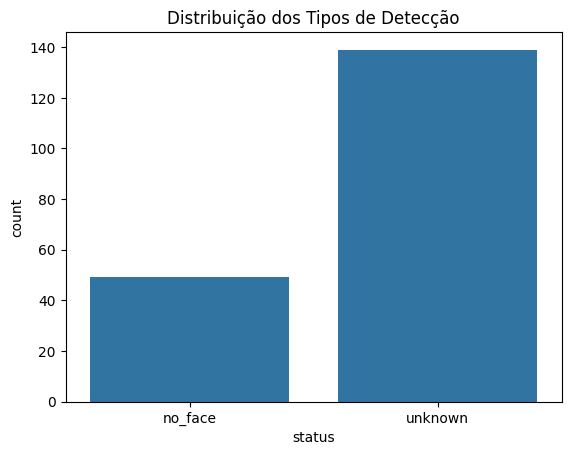

In [10]:
# Distribuição de status
sns.countplot(data=df, x='status')
plt.title('Distribuição dos Tipos de Detecção')
plt.show()

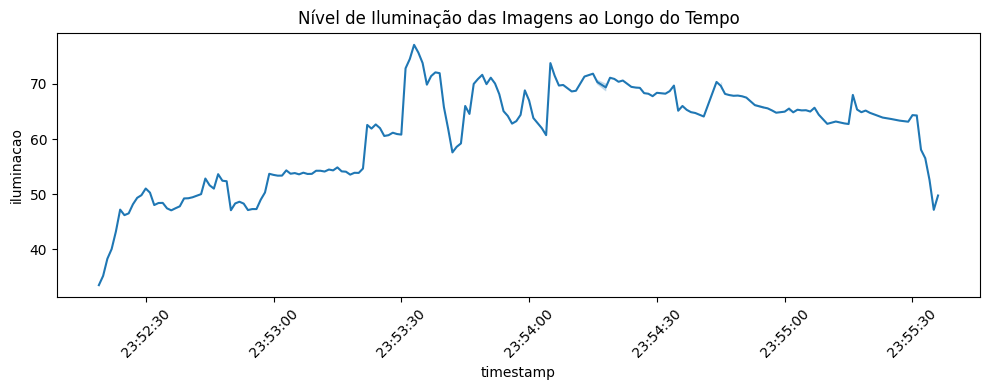

In [11]:
# Iluminação ao longo do tempo
plt.figure(figsize=(10, 4))
sns.lineplot(data=df, x='timestamp', y='iluminacao')
plt.title('Nível de Iluminação das Imagens ao Longo do Tempo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

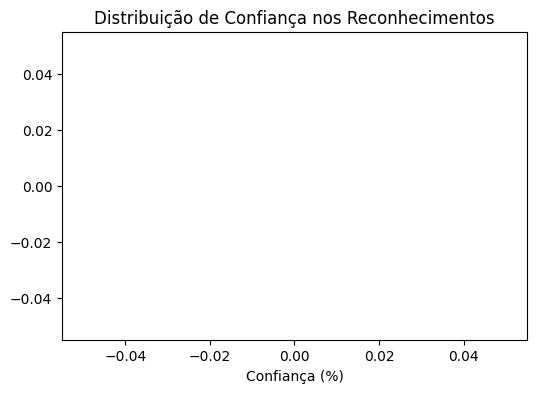

In [12]:
# Confiança dos reconhecimentos (quando disponível)
df_conf = df[df['confianca'].notnull()]
plt.figure(figsize=(6, 4))
sns.histplot(df_conf['confianca'], bins=10, kde=True)
plt.title('Distribuição de Confiança nos Reconhecimentos')
plt.xlabel('Confiança (%)')
plt.show()

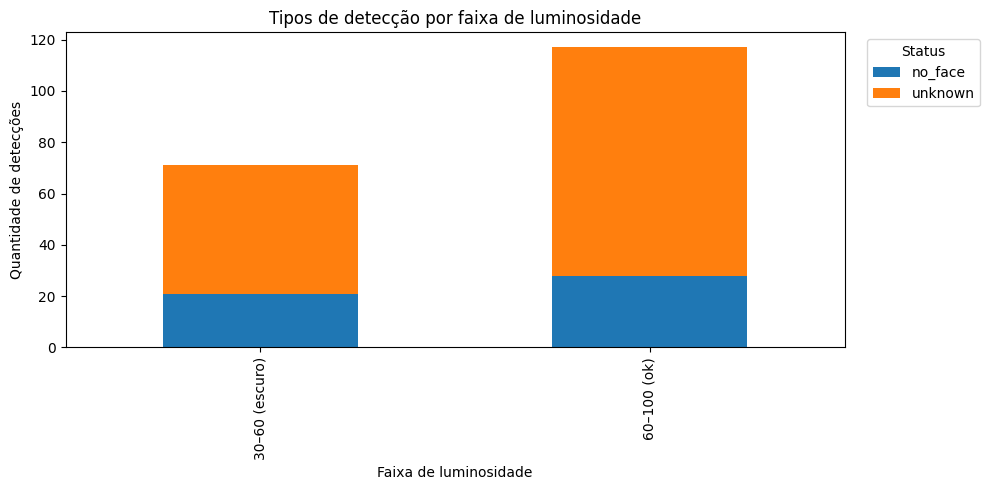

In [13]:
grafico_barras_empilhadas_por_luz(df)

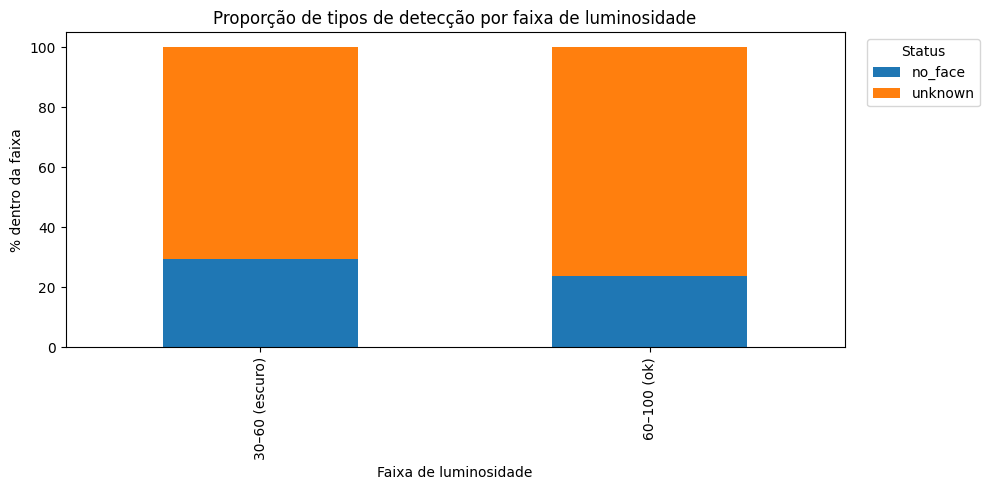

In [14]:
grafico_percentual_por_luz(df)

In [16]:
# Conta os registros em cada faixa
contagem = df["faixa_luz"].value_counts().sort_index()

print(contagem)

faixa_luz
0–30 (muito escuro)        0
30–60 (escuro)            71
60–100 (ok)              117
100–150 (claro)            0
150–255 (muito claro)      0
>=255 (estourado)          0
Name: count, dtype: int64


In [17]:
# 1) Ordena por timestamp para garantir sequência correta
df = df.sort_values("timestamp")

# 2) Calcula a diferença de tempo entre requisições
df["tempo_entre_requisicoes"] = df["timestamp"].diff()

# Tempo médio entre requisições
tempo_medio_requisicoes = df["tempo_entre_requisicoes"].mean()
print("Tempo médio entre requisições:", tempo_medio_requisicoes)

# Em segundos
print("Tempo médio (s):", tempo_medio_requisicoes.total_seconds())

Tempo médio entre requisições: 0 days 00:00:01.053475935
Tempo médio (s): 1.053475


In [18]:
# 3) Tempo médio de latência (resposta do Flask)
tempo_medio_latencia = df["tempo_resposta_ms"].mean()
print("Tempo médio de latência (ms):", tempo_medio_latencia)

# 4) Estatísticas extras
print("Latência mínima (ms):", df["tempo_resposta_ms"].min())
print("Latência máxima (ms):", df["tempo_resposta_ms"].max())

Tempo médio de latência (ms): 310.8856914893617
Latência mínima (ms): 89.03
Latência máxima (ms): 1957.54


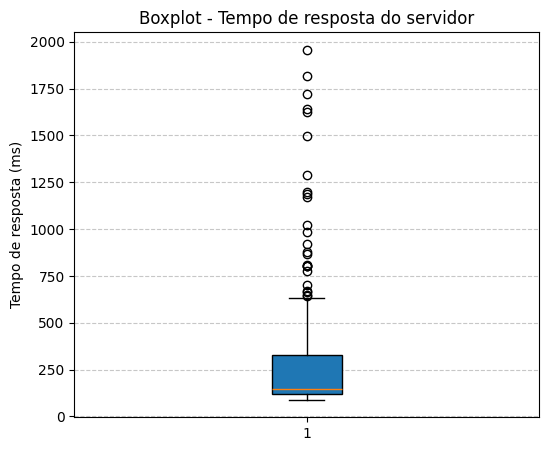

In [19]:
# Filtra apenas valores válidos
df_valid = df[df["tempo_resposta_ms"].notnull()]

plt.figure(figsize=(6, 5))
plt.boxplot(df_valid["tempo_resposta_ms"], vert=True, patch_artist=True)

plt.title("Boxplot - Tempo de resposta do servidor")
plt.ylabel("Tempo de resposta (ms)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

Removidos 25 outliers


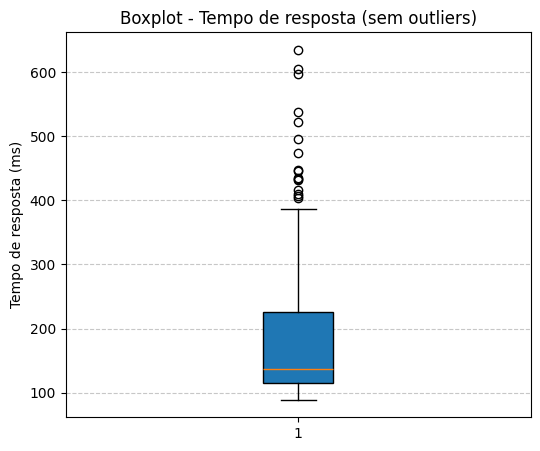

In [20]:
# Supondo que já tenha o DataFrame
df_valid = df[df["tempo_resposta_ms"].notnull()].copy()

# Calcula Q1 (25%) e Q3 (75%)
Q1 = df_valid["tempo_resposta_ms"].quantile(0.25)
Q3 = df_valid["tempo_resposta_ms"].quantile(0.75)
IQR = Q3 - Q1

# Define limites inferior e superior
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtra sem outliers
df_sem_outliers = df_valid[
    (df_valid["tempo_resposta_ms"] >= limite_inferior) &
    (df_valid["tempo_resposta_ms"] <= limite_superior)
]

print(f"Removidos {len(df_valid) - len(df_sem_outliers)} outliers")

# Plota boxplot sem outliers
plt.figure(figsize=(6, 5))
plt.boxplot(df_sem_outliers["tempo_resposta_ms"], vert=True, patch_artist=True)

plt.title("Boxplot - Tempo de resposta (sem outliers)")
plt.ylabel("Tempo de resposta (ms)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()